In [54]:
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import astropy.constants as const
import scipy
from matplotlib import gridspec
from astropy.io import fits
import pickle
from pickle import *
import time
import math
import re
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize
from astropy.table import Table
import itertools
from scipy.interpolate import interp1d

# Nenkova et al. (2008) model

According to *The Astrophysical Journal, 685(1), 160* the free parameters of the model are: $Y$, $\mathcal{N}_o$, $q$, $\tau_v$, $\sigma$ y $i$.

In [2]:
npzfile = np.load('Models/nenkova_v0_files.npz')  
print(type(npzfile))
print(npzfile.files)  # List of files that contain the following data: wavelength, SED and parameters

<class 'numpy.lib.npyio.NpzFile'>
['arr_1', 'arr_0', 'arr_2']


Now, we print each file to identify it.

In [3]:
npzfile['arr_0'] #Observation angle

array([10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [4]:
npzfile['arr_1'] #Log(nu)

array([[11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       ...,
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
       [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768]])

In [5]:
npzfile['arr_2'] # SED

array([[2.52925073e-73, 1.22105908e-72, 5.68080811e-72, ...,
        1.21524045e-72, 8.10714442e-73, 4.74898149e-73],
       [2.53057801e-73, 1.22177283e-72, 5.68740672e-72, ...,
        1.19830533e-72, 7.99963317e-73, 4.70119967e-73],
       [2.53363073e-73, 1.22293269e-72, 5.69040609e-72, ...,
        1.14399617e-72, 7.63728045e-73, 4.49945423e-73],
       ...,
       [2.53628528e-73, 1.22275425e-72, 5.68200785e-72, ...,
        5.55646942e-73, 3.69420591e-73, 2.11699985e-73],
       [2.53588710e-73, 1.22230815e-72, 5.67600911e-72, ...,
        4.33188546e-73, 2.87970867e-73, 1.64794170e-73],
       [2.53535619e-73, 1.22177283e-72, 5.67360962e-72, ...,
        3.99259920e-73, 2.65154591e-73, 1.51601080e-73]])

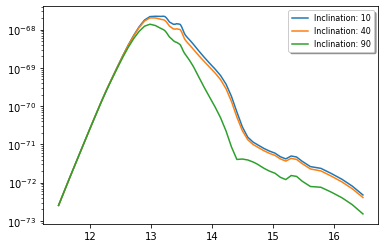

In [6]:
plt.semilogy(npzfile['arr_1'][0], npzfile['arr_2'][0], label = 'Inclination: 10')
plt.semilogy(npzfile['arr_1'][3], npzfile['arr_2'][3], label = 'Inclination: 40')
plt.semilogy(npzfile['arr_1'][8], npzfile['arr_2'][8], label = 'Inclination: 90')
plt.legend(fontsize = 8, shadow = True)

In [7]:
#write the pickle file with the dictionary
incl, torus_wv, torus_SED = npzfile['arr_0'], npzfile['arr_1'], npzfile['arr_2']
NK0 = {'SED' : torus_SED, 'wavelength' : torus_wv, 'incl-values' : incl}
f1 = open('Models/nenkova_v0.pickle', 'wb')
pickle.dump(NK0, f1, protocol=2)
f1.close()


In [8]:
NK0dict = pickle.load(open('Models/nenkova_v0.pickle', 'rb'), encoding='latin1')  
NK0dict

{'SED': array([[2.52925073e-73, 1.22105908e-72, 5.68080811e-72, ...,
         1.21524045e-72, 8.10714442e-73, 4.74898149e-73],
        [2.53057801e-73, 1.22177283e-72, 5.68740672e-72, ...,
         1.19830533e-72, 7.99963317e-73, 4.70119967e-73],
        [2.53363073e-73, 1.22293269e-72, 5.69040609e-72, ...,
         1.14399617e-72, 7.63728045e-73, 4.49945423e-73],
        ...,
        [2.53628528e-73, 1.22275425e-72, 5.68200785e-72, ...,
         5.55646942e-73, 3.69420591e-73, 2.11699985e-73],
        [2.53588710e-73, 1.22230815e-72, 5.67600911e-72, ...,
         4.33188546e-73, 2.87970867e-73, 1.64794170e-73],
        [2.53535619e-73, 1.22177283e-72, 5.67360962e-72, ...,
         3.99259920e-73, 2.65154591e-73, 1.51601080e-73]]),
 'wavelength': array([[11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
        [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
        [11.4768, 11.6493, 11.8217, ..., 16.1344, 16.3007, 16.4768],
        ...,
        [11.4768, 11.649

# SKIRTOR

(1e-17, 1e-10)

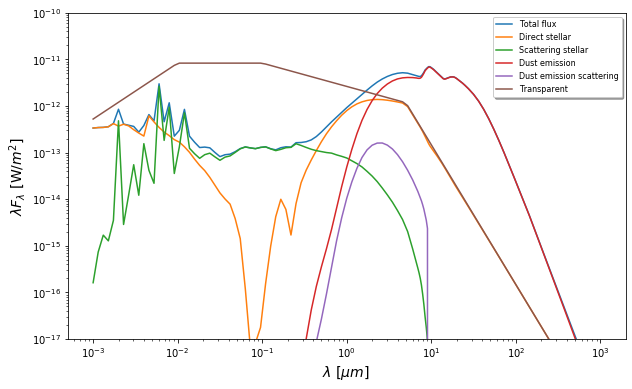

In [2]:
SED = pd.read_csv("Models/SKIRTOR/skirtor_2016-7-18/t3_p0_q0.5_oa40_R10_Mcl0.97_i50_sed.dat", delim_whitespace=True, decimal=".", names= ['wl', 'TwlFwl', 'DSwlFwl', 'SSwlFwl', 'TDwlFwl', 'SDwlFwl', 'TrwlFwl'], skiprows = 7)
c = 2.997e8    #m/s
wl = SED.iloc[:, 0]*1e-6  #m
nu = c/wl  #Hz
nu = nu[::-1]
log_nu = np.log10(nu)

d = 3.086*1e22 # 10 Mpc in m just information
F_l = SED.iloc[:, 4]/wl
F_nu = (F_l*wl**2)/c  #W/m²Hz 
F_nu = F_nu[::-1]
F_nu2 = F_nu/(4*np.pi*d**2)  # just scale factor

fig = plt.figure(figsize=(10, 6))
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 1], label = 'Total flux')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 2], label = 'Direct stellar')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 3], label = 'Scattering stellar')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 4], label = 'Dust emission')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 5], label = 'Dust emission scattering')
plt.loglog(SED.iloc[:, 0], SED.iloc[:, 6], label = 'Transparent')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'$\lambda$ [$\mu m$] ', fontsize = 14) 
plt.ylabel(r'$\lambda F_\lambda$ [W/$m^2$] ', fontsize = 14) 
plt.ylim(1e-17, 1e-10)

(1e-10, 1e-05)

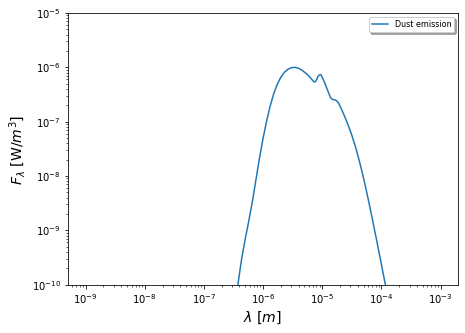

In [10]:
fig = plt.figure(figsize=(7, 5))
plt.loglog(wl, SED.iloc[:, 4]/wl, label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'$\lambda$ [$m$] ', fontsize = 14) 
plt.ylabel(r'$F_\lambda$ [W/$m^3$] ', fontsize = 14) 
plt.ylim(1e-10, 1e-5)

(1e-17, 1e-10)

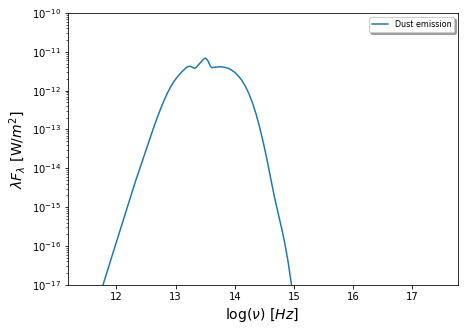

In [11]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, SED.iloc[:, 4][::-1], label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\lambda F_\lambda$ [W/$m^2$] ', fontsize = 14) 
plt.ylim(1e-17, 1e-10)

(1e-18, 1e-10)

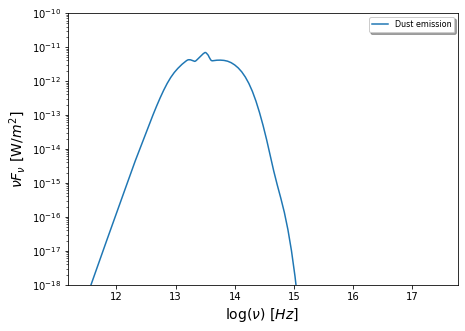

In [12]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, (nu*F_nu), label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [W/$m^2$] ', fontsize = 14) 
plt.ylim(1e-18, 1e-10)

(1e-76, 1e-70)

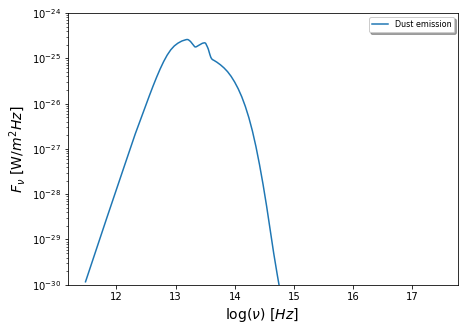

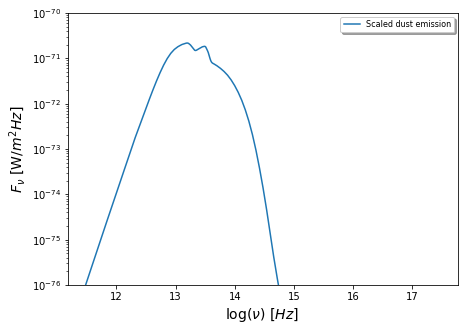

In [4]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, F_nu, label = 'Dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-30, 1e-24)
#plt.ylim(1e-10, 1e-4)

fig = plt.figure(figsize=(7, 5))
plt.semilogy(log_nu, F_nu2, label = 'Scaled dust emission')
plt.legend(fontsize = 8, shadow = True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-76, 1e-70)

In [15]:
DustM = pd.read_csv("Models/SKIRTOR/total_dust_mass_2016-7-18.txt", sep = '    ', decimal=".", names= ['model', 'Mass'], skiprows = 2, engine = 'python')

In [16]:
nombre = 't3_p0_q0.5_oa40_R10_Mcl0.97_i50_sed.dat'

#A way to split the string a read the information about each SED
sep = [m.start() for m in re.finditer('_', nombre)]
print(nombre[nombre.find('t')+1: sep[0]])
print(nombre[nombre.find('p')+1: sep[1]])
print(nombre[nombre.find('q')+1: sep[2]])
print(nombre[nombre.find('oa')+2: sep[3]])
print(nombre[nombre.find('R')+1: sep[4]])
print(nombre[nombre.find('Mcl')+3: sep[5]])
print(nombre[nombre.find('i')+1: sep[6]])
print(nombre[: sep[5]])
print(DustM[DustM['model'] == nombre[: sep[5]]]['Mass'])

3
0
0.5
40
10
0.97
50
t3_p0_q0.5_oa40_R10_Mcl0.97
489    419.004 Msun
Name: Mass, dtype: object


In [13]:
# It's necessary to obtaine the value (str) and transform it into float
float(DustM[DustM['model'] == nombre[: sep[5]]]['Mass'].values.item()[:-5])

419.004

In [109]:
#Code to create the dictionary with all the information of each SED
column_names = ["wavelength", 'SED', 'tv-values', 'p-values', 'q-values', 'oa-values', 'r-values', 'mcl-values', 'incl-values', 'Dm-values']  #To create the columns of the dataframe
SKIRTOR = pd.DataFrame(columns = column_names)
DustM = pd.read_csv("Models/SKIRTOR/total_dust_mass_2016-7-18.txt", sep = '    ', decimal=".", names= ['model', 'Mass'], skiprows = 2, engine = 'python')
j = 0

for i in os.listdir("Models/SKIRTOR/prueba"):
    data = pd.read_csv("Models/SKIRTOR/prueba/" + i, delim_whitespace=True, decimal=".", names= ['wl', 'TwlFwl', 'DSwlFwl', 'SSwlFwl', 'TDwlFwl', 'SDwlFwl', 'TrwlFwl'], skiprows = 7)
    
    c = 2.997e8
    log_nu = np.log10(c/(data.iloc[:, 0]*1e-6))
    log_nu = log_nu[::-1]

    d = 3.086*1e25 # 10 Mpc
    F_l = data.iloc[:, 4]/(data.iloc[:, 0]*4*np.pi*d**2)
    F_nu = F_l[::-1]
    
    sep = [m.start() for m in re.finditer('_', i)]
    tv = float(i[i.find('t')+1: sep[0]])
    p = float(i[i.find('p')+1: sep[1]])
    q = float(i[i.find('q')+1: sep[2]])
    oa = float(i[i.find('oa')+2: sep[3]])
    r = float(i[i.find('R')+1: sep[4]])
    mcl = float(i[i.find('Mcl')+3: sep[5]])
    incl = float(i[i.find('i')+1: sep[6]])
    Md = float(DustM[DustM['model'] == i[: sep[5]]]['Mass'].values.item()[:-5])
    
    New_row = {'SED': F_nu, 'wavelength': log_nu, 'tv-values': tv, 'p-values': p, 'q-values': q, 'oa-values': oa, 'r-values': r, 'mcl-values': mcl, 'incl-values': incl, 'Dm-values': Md} 
    SKIRTOR = SKIRTOR.append(New_row, ignore_index = True) 
    j += 1
    if j == 3840:
        print('20$\%$ of the finished process...')
    elif j == 7680:
        print('40$\%$ of the finished process...')
    elif j == 11520:
        print('60$\%$ of the finished process...')
    elif j == 15360:
        print('80$\%$ of the finished process...')
    elif j == 19199:
        print('Completed process.')

In [110]:
SKIRTOR

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
0,131 11.476687 130 11.536687 129 11.59...,131 2.321010e-74 130 5.244959e-74 129 ...,3.0,0.5,0.5,20.0,20.0,0.97,10.0,662.1960
1,131 11.476687 130 11.536687 129 11.59...,131 2.320947e-74 130 5.244773e-74 129 ...,3.0,0.5,0.5,20.0,20.0,0.97,50.0,662.1960
2,131 11.476687 130 11.536687 129 11.59...,131 8.852830e-75 130 2.006639e-74 129 ...,3.0,0.5,0.5,20.0,10.0,0.97,30.0,187.6690
3,131 11.476687 130 11.536687 129 11.59...,131 1.603092e-74 130 3.600531e-74 129 ...,3.0,0.5,0.5,10.0,30.0,0.97,60.0,738.7750
4,131 11.476687 130 11.536687 129 11.59...,131 8.644745e-75 130 1.946334e-74 129 ...,3.0,0.5,0.5,10.0,20.0,0.97,40.0,345.4870
5,131 11.476687 130 11.536687 129 11.59...,131 3.091124e-75 130 6.987020e-75 129 ...,3.0,0.5,0.5,10.0,10.0,0.97,0.0,98.0076
6,131 11.476687 130 11.536687 129 11.59...,131 1.603115e-74 130 3.600600e-74 129 ...,3.0,0.5,0.5,10.0,30.0,0.97,50.0,738.7750
7,131 11.476687 130 11.536687 129 11.59...,131 8.852628e-75 130 2.006578e-74 129 ...,3.0,0.5,0.5,20.0,10.0,0.97,50.0,187.6690
8,131 11.476687 130 11.536687 129 11.59...,131 1.603139e-74 130 3.600670e-74 129 ...,3.0,0.5,0.5,10.0,30.0,0.97,30.0,738.7750
9,131 11.476687 130 11.536687 129 11.59...,131 8.851937e-75 130 2.006372e-74 129 ...,3.0,0.5,0.5,20.0,10.0,0.97,70.0,187.6690


In [8]:
SKIRTORdict = pickle.load(open('Models/SKIRTOR.pickle', 'rb'), encoding='latin1')  

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
0,131 11.476687 130 11.536687 129 11.59...,131 4.916406e-76 130 8.469030e-76 129 ...,5.0,1.0,0.5,70.0,20.0,0.97,80.0,1722.370
1,131 11.476687 130 11.536687 129 11.59...,131 2.626583e-76 130 4.517134e-76 129 ...,11.0,0.0,0.0,30.0,10.0,0.97,30.0,1393.130
2,131 11.476687 130 11.536687 129 11.59...,131 3.780430e-76 130 6.486721e-76 129 ...,9.0,0.0,1.5,30.0,20.0,0.97,20.0,3046.850
3,131 11.476687 130 11.536687 129 11.59...,131 4.705114e-76 130 8.100102e-76 129 ...,5.0,1.5,0.5,70.0,30.0,0.97,0.0,1723.650
4,131 11.476687 130 11.536687 129 11.59...,131 9.744822e-77 130 1.679536e-76 129 ...,3.0,0.0,0.5,40.0,10.0,0.97,50.0,419.004
...,...,...,...,...,...,...,...,...,...,...
19195,131 11.476687 130 11.536687 129 11.59...,131 3.230850e-76 130 5.568634e-76 129 ...,9.0,0.0,1.0,50.0,10.0,0.97,50.0,1225.920
19196,131 11.476687 130 11.536687 129 11.59...,131 9.244661e-77 130 1.585096e-76 129 ...,3.0,0.0,1.0,20.0,20.0,0.97,50.0,832.003
19197,131 11.476687 130 11.536687 129 11.59...,131 8.716065e-76 130 1.503236e-75 129 ...,11.0,0.0,0.5,80.0,10.0,0.97,20.0,2180.960
19198,131 11.476687 130 11.536687 129 11.59...,131 1.041018e-76 130 1.768757e-76 129 ...,7.0,0.5,1.0,10.0,30.0,0.97,0.0,1653.870


In [9]:
SKIRTORdict['oa-values'].unique()

array([70., 30., 40., 80., 50., 20., 60., 10.])

In [27]:
int_par, dec_par = divmod(15, 8)

print(int_par*10)
print(dec_par*10+10)

10
80


In [19]:
import itertools

#itertools let us to create a parameters combinatorial, it's used in MODEL_AGNfitter.py
idxs = [np.array([1,2,3]), np.array([3,5]), np.array([1,7])]
par_idxs_combinations = np.array(list(itertools.product(*idxs)))
par_idxs_combinations

array([[1, 3, 1],
       [1, 3, 7],
       [1, 5, 1],
       [1, 5, 7],
       [2, 3, 1],
       [2, 3, 7],
       [2, 5, 1],
       [2, 5, 7],
       [3, 3, 1],
       [3, 3, 7],
       [3, 5, 1],
       [3, 5, 7]])

In [20]:
#Filtering test
prueba1 = SKIRTORdict[(SKIRTORdict['tv-values'] == 3) & (SKIRTORdict['p-values'] == 0)& (SKIRTORdict['q-values'] == 0.5)& (SKIRTORdict['oa-values'] == 40) & (SKIRTORdict['r-values'] == 10) & (SKIRTORdict['mcl-values'] == 0.97) & (SKIRTORdict['incl-values'] == 50)]
prueba1

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
4,131 11.476687 130 11.536687 129 11.59...,131 2.920523e-74 130 6.635538e-74 129 ...,3.0,0.0,0.5,40.0,10.0,0.97,50.0,419.004


In [21]:
# .values.item().to_numpy() let us to transform a pandas series to a numpy array (needed in MODEL_AGNfitter.py)
tor_nu0, tor_Fnu0 =  prueba1['wavelength'].values.item().to_numpy(),prueba1['SED'].values.item().to_numpy()
tor_nu0, tor_Fnu0

(array([11.47668674, 11.53668674, 11.59668674, 11.65668674, 11.71668674,
        11.77668674, 11.83668674, 11.89668674, 11.95668674, 12.01668674,
        12.07668674, 12.13668674, 12.19668674, 12.25668674, 12.31668674,
        12.37668674, 12.43668674, 12.49668674, 12.55668674, 12.61668674,
        12.67668674, 12.73668674, 12.79668674, 12.85668674, 12.91668674,
        12.97668674, 13.03668674, 13.07874673, 13.09304336, 13.10734   ,
        13.12163662, 13.13593325, 13.15022988, 13.16452652, 13.17882314,
        13.19311978, 13.20741641, 13.22171304, 13.23600967, 13.2503063 ,
        13.26460293, 13.27889956, 13.29319619, 13.30749282, 13.32178945,
        13.33608608, 13.35038271, 13.36467934, 13.37897597, 13.3932726 ,
        13.40756923, 13.42186586, 13.43616249, 13.45045912, 13.46475575,
        13.47905238, 13.49334901, 13.50764564, 13.52194227, 13.5362389 ,
        13.55053553, 13.56483216, 13.57912879, 13.59342542, 13.60772205,
        13.62201868, 13.63631531, 13.65061194, 13.6

In [22]:
SKIRTORCdict = pickle.load(open('Models/SKIRTOR_CIGALE.pickle', 'rb'), encoding='latin1')  
SKIRTORCdict = SKIRTORCdict.sort_values('incl-values', ascending=True)
SKIRTORCdict

,wavelength,SED,tv-values,p-values,q-values,oa-values,r-values,mcl-values,incl-values,Dm-values
6,131 11.476687 130 11.536687 129 11.59...,131 2.722766e-76 130 4.681085e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,0.0,1520.55
2,131 11.476687 130 11.536687 129 11.59...,131 2.722764e-76 130 4.681074e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,10.0,1520.55
4,131 11.476687 130 11.536687 129 11.59...,131 2.722751e-76 130 4.681050e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,20.0,1520.55
3,131 11.476687 130 11.536687 129 11.59...,131 2.722717e-76 130 4.680973e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,30.0,1520.55
9,131 11.476687 130 11.536687 129 11.59...,131 2.722656e-76 130 4.680827e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,40.0,1520.55
0,131 11.476687 130 11.536687 129 11.59...,131 2.722541e-76 130 4.680580e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,50.0,1520.55
5,131 11.476687 130 11.536687 129 11.59...,131 2.722382e-76 130 4.680208e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,60.0,1520.55
8,131 11.476687 130 11.536687 129 11.59...,131 2.722230e-76 130 4.679863e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,70.0,1520.55
7,131 11.476687 130 11.536687 129 11.59...,131 2.722127e-76 130 4.679622e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,80.0,1520.55
1,131 11.476687 130 11.536687 129 11.59...,131 2.722082e-76 130 4.679535e-76 129 ...,7.0,1.0,1.0,40.0,20.0,0.97,90.0,1520.55


<class 'pandas.core.series.Series'>


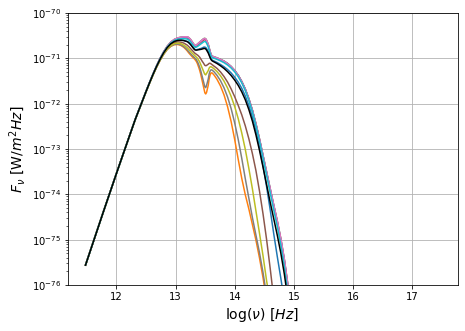

In [23]:
#Test to calculate mean values of a numpy array

SEDs = [np.zeros((132))]*2
fig = plt.figure(figsize=(7, 5))
for i in range(10):
    plt.semilogy(SKIRTORCdict['wavelength'][i], SKIRTORCdict['SED'][i])
    SEDs[1] += SKIRTORCdict['SED'][i]/10
#SEDmean = SEDs/10
plt.semilogy(SKIRTORCdict['wavelength'][0], SEDs[1], color = 'black')
plt.ylim(1e-29, 1e-24)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^2 Hz$] ', fontsize = 14) 
plt.ylim(1e-76, 1e-70)
print(type(SEDs[1]))

In [24]:
SKIRTORMdict = pickle.load(open('Models/SKIRTOR_mean.pickle', 'rb'), encoding='latin1')  
SKIRTORMdict

,wavelength,SED,incl-values,Dm-values
0,131 11.476687 130 11.536687 129 11.59...,131 4.696267e-76 130 8.074933e-76 129 ...,0.0,2418.060767
1,131 11.476687 130 11.536687 129 11.59...,131 4.699164e-76 130 8.079921e-76 129 ...,10.0,2418.060767
2,131 11.476687 130 11.536687 129 11.59...,131 4.697193e-76 130 8.076537e-76 129 ...,20.0,2418.060767
3,131 11.476687 130 11.536687 129 11.59...,131 4.697300e-76 130 8.076686e-76 129 ...,30.0,2418.060767
4,131 11.476687 130 11.536687 129 11.59...,131 4.683712e-76 130 8.053274e-76 129 ...,40.0,2418.060767
5,131 11.476687 130 11.536687 129 11.59...,131 4.698353e-76 130 8.078358e-76 129 ...,50.0,2418.060767
6,131 11.476687 130 11.536687 129 11.59...,131 4.709018e-76 130 8.096599e-76 129 ...,60.0,2418.060767
7,131 11.476687 130 11.536687 129 11.59...,131 4.700622e-76 130 8.082067e-76 129 ...,70.0,2418.060767
8,131 11.476687 130 11.536687 129 11.59...,131 4.694166e-76 130 8.070867e-76 129 ...,80.0,2418.060767
9,131 11.476687 130 11.536687 129 11.59...,131 4.697808e-76 130 8.077090e-76 129 ...,90.0,2418.060767


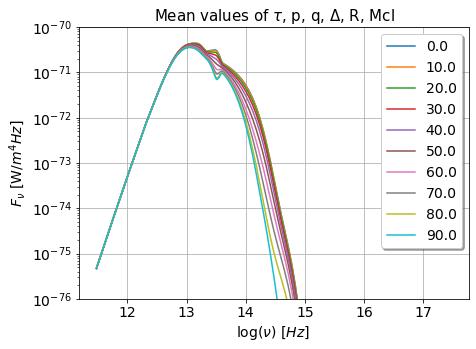

In [28]:
#Plot of the SKIRTOR SEDs obtained using the mean values of the parameters as Sussana and Gabriela did with Nenkova

fig = plt.figure(figsize=(7, 5))
for i in range(10):
    plt.semilogy(SKIRTORMdict['wavelength'][i], SKIRTORMdict['SED'][i], label = str(SKIRTORMdict['incl-values'][i]))
plt.title(r'Mean values of $\tau$, p, q, $\Delta$, R, Mcl', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(fontsize = 14, shadow = True)
plt.grid(True)
plt.ylim(1e-76, 1e-70)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^4 Hz$] ', fontsize = 14) 
plt.show()

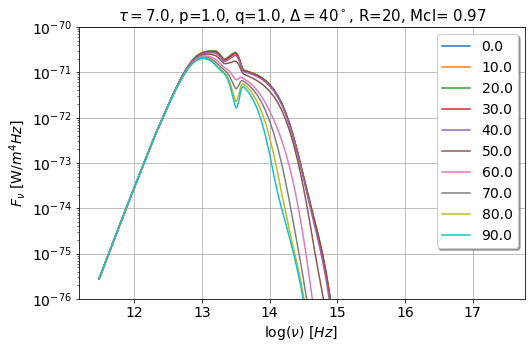

In [29]:
#Plot of the SKIRTOR SEDs obtained using the parameters values of the X-CIGALE paper

fig = plt.figure(figsize=(8, 5))
for i in range(10):
    plt.semilogy(SKIRTORCdict['wavelength'].iloc[i], SKIRTORCdict['SED'].iloc[i], label = str(SKIRTORCdict['incl-values'].iloc[i]))
plt.title(r'$\tau=7.0$, p=1.0, q=1.0, $\Delta=40^\circ$, R=20, Mcl= 0.97', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend(fontsize = 14, shadow = True)
plt.ylim(1e-76, 1e-70)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [W/$m^4 Hz$] ', fontsize = 14) 
plt.show()

In [36]:
SKIRTOR_2p_dict = pickle.load(open('Models/SKIRTOR_mean_2p.pickle', 'rb'), encoding='latin1')  
SKIRTOR_2p_dict.iloc[0:17]

,wavelength,SED,incl-values,Dm-values,oa-values
0,131 11.476687 130 11.536687 129 11.59...,131 1.872787e-76 130 3.212067e-76 129 ...,0.0,754.263117,10.0
1,131 11.476687 130 11.536687 129 11.59...,131 2.707580e-76 130 4.643679e-76 129 ...,0.0,1423.529956,20.0
2,131 11.476687 130 11.536687 129 11.59...,131 3.907485e-76 130 6.707876e-76 129 ...,0.0,1989.550983,30.0
3,131 11.476687 130 11.536687 129 11.59...,131 5.419699e-76 130 9.312639e-76 129 ...,0.0,2457.291629,40.0
4,131 11.476687 130 11.536687 129 11.59...,131 6.563464e-76 130 1.128561e-75 129 ...,0.0,2832.205521,50.0
5,131 11.476687 130 11.536687 129 11.59...,131 7.796766e-76 130 1.341363e-75 129 ...,0.0,3119.515708,60.0
6,131 11.476687 130 11.536687 129 11.59...,131 8.162410e-76 130 1.404850e-75 129 ...,0.0,3323.081292,70.0
7,131 11.476687 130 11.536687 129 11.59...,131 1.038478e-75 130 1.787477e-75 129 ...,0.0,3445.047933,80.0
8,131 11.476687 130 11.536687 129 11.59...,131 1.528399e-76 130 2.619977e-76 129 ...,10.0,754.263117,10.0
9,131 11.476687 130 11.536687 129 11.59...,131 2.675512e-76 130 4.588519e-76 129 ...,10.0,1423.529956,20.0


# Test with accretion disc

In [123]:
SN12dict = pickle.load(open('Models/SN12.pickle', 'rb'), encoding='latin1') 
SN12dict

{'description': ['Model created based on Slone and Netzer 2012. Obtained through private communication with H. Netzer.                              UNITS: logBHmass[log Mbh / Musn], EddRatio[log Mdot/Medd], SED[ergs/s/Hz], freq[Hz]'],
 'parameters': ['logBHmass', 'logEddra'],
 'logBHmass-values': array([7.4, 7.7, 8. , 8.3, 8.6, 8.9, 9.2, 9.5, 9.8]),
 'logEddra-values': array([0.00000e+00, 1.00000e-03, 2.00000e-03, 3.00000e-03, 4.00000e-03,
        5.00000e-03, 6.00000e-03, 7.00000e-03, 8.00000e-03, 9.00000e-03,
        1.00000e-02, 1.10000e-02, 1.20000e-02, 1.30000e-02, 1.40000e-02,
        1.50000e-02, 1.60000e-02, 1.70000e-02, 1.80000e-02, 1.90000e-02,
        2.00000e-02, 2.10000e-02, 2.20000e-02, 2.30000e-02, 2.40000e-02,
        2.50000e-02, 2.60000e-02, 2.80000e-02, 2.90000e-02, 3.00000e-02,
        3.10000e-02, 3.40000e-02, 3.60000e-02, 3.80000e-02, 3.90000e-02,
        4.00000e-02, 4.20000e-02, 4.40000e-02, 4.50000e-02, 4.80000e-02,
        5.00000e-02, 5.20000e-02, 5.50000e-02

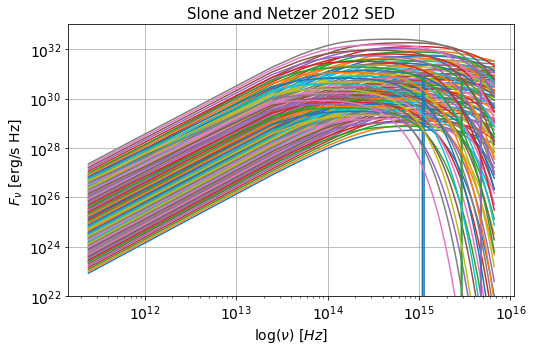

In [124]:
fig = plt.figure(figsize=(8, 5))
for i in range(9):
    for j in range(12):
        plt.loglog(SN12dict['frequency'], SN12dict['SED'][:, i, j])
        
plt.ylim(1e22, 1e33)
plt.title(r'Slone and Netzer 2012 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

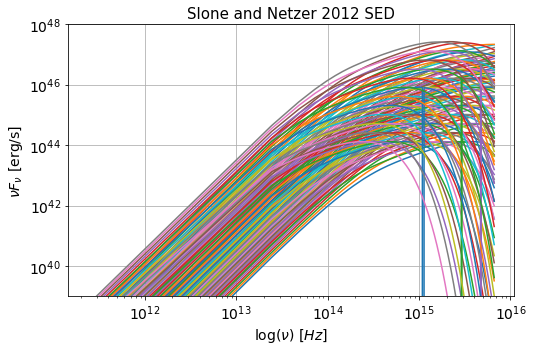

In [125]:
fig = plt.figure(figsize=(8, 5))
for i in range(9):
    for j in range(12):
        plt.loglog(SN12dict['frequency'], SN12dict['SED'][:, i, j]*SN12dict['frequency'])
        
plt.ylim(1e39, 1e48)
plt.title(r'Slone and Netzer 2012 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
#plt.legend(fontsize = 14, shadow = True)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.show()

In [52]:
#Richards models is a unique SED
R06dict = pickle.load(open('Models/R06.pickle', 'rb'), encoding='latin1') 

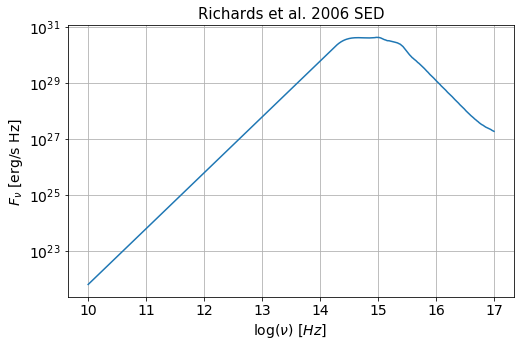

In [60]:
f = 10**R06dict['wavelength']
fig = plt.figure(figsize=(8, 5))

plt.semilogy(R06dict['wavelength'], R06dict['SED'])
        
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()

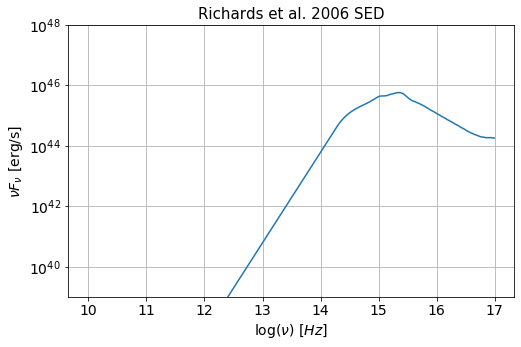

In [61]:
f = 10**R06dict['wavelength']
fig = plt.figure(figsize=(8, 5))

plt.semilogy(R06dict['wavelength'], R06dict['SED']*f)
        
plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.show()

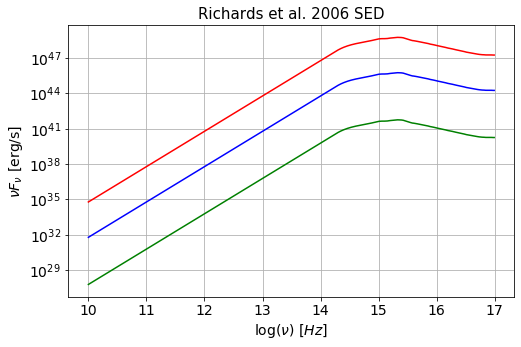

In [62]:
f = 10**R06dict['wavelength']
fig = plt.figure(figsize=(8, 5))

plt.semilogy(R06dict['wavelength'], R06dict['SED']*f*10**(-4), color = 'g')
plt.semilogy(R06dict['wavelength'], R06dict['SED']*f, color = 'b')
plt.semilogy(R06dict['wavelength'], R06dict['SED']*f*10**(3), color = 'r')        
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
plt.show()

# Minimization routine

In [31]:
def Best_BB(SN12_f, SN12_SED, BH_mass, EddR, BB):
    
    distances = np.zeros((len(BB)))
    #BB = np.linspace(-4, 3, 700)
    for i in range(len(BB)):
        R06 = np.zeros((438, 2))
        R06[:, 0] = 10**R06dict['wavelength']
        R06[:, 1] = R06dict['SED']*R06[:, 0]*10**BB[i]

        SN12 = np.zeros((276, 2))
        SN12[:, 0] = SN12_f
        SN12[:, 1] = SN12_SED*SN12_f

        distances[i] = np.sum(distance.cdist(R06, SN12, 'euclidean'))
        #print(distance.cdist(R06, SN12, 'euclidean').shape)
    
    dis_min = distances.min()  ## np.argmin()
    pos_min = np.where(distances == dis_min)[0][0]
    
    fig = plt.figure(figsize=(8, 5))
    plt.loglog(R06[:, 0], R06dict['SED']*R06[:, 0]*10**BB[pos_min], label = 'BB = ' + str(BB[pos_min])) 
    plt.loglog(SN12_f, SN12_SED*SN12_f, label = 'BH_mass = {}, EddR = {}'.format(BH_mass, EddR))
    plt.legend(fontsize = 10, shadow = True)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.grid(True)
    plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
    plt.ylabel(r'$\nu F_\nu$ [erg/s] ', fontsize = 14) 
    plt.close()
    return BB[pos_min], fig


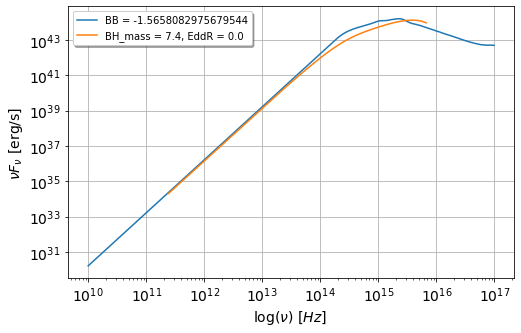

In [32]:
Best_BB(SN12dict['frequency'], SN12dict['SED'][:, 0, 0], SN12dict['logBHmass-values'][0], SN12dict['logEddra-values'][0],  np.linspace(-4.5, 2.5, 700))[1]

In [11]:
parameters = np.zeros((108,3))
bb_matrix = np.zeros((9,12))
k = 0
for i in range(9):
    for j in range(12):
        MBH = SN12dict['logBHmass-values'][i]
        EddR = SN12dict['logEddra-values'][j]
        BB = Best_BB(SN12dict['frequency'], SN12dict['SED'][:, i, j], MBH, EddR, np.linspace(-12.0, 2.0, 1000))[0]
        parameters[k]= [BB, MBH, EddR]
        bb_matrix[i,j] = BB
        k += 1
        if k == 27:
            print('25 % of the finished process...')
        elif k == 54:
            print('50 % of the finished process...')
        elif k == 81:
            print('75 % of the finished process...')
        elif k == 108:
            print('100 % of the finished process...')

25 % of the finished process...
50 % of the finished process...
75 % of the finished process...
100 % of the finished process...


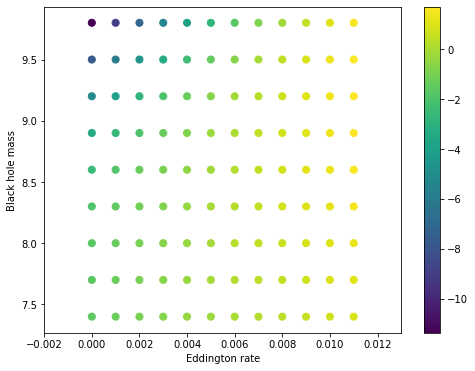

In [12]:
bb = parameters[:,0]
Mbh = parameters[:,1]
Edd_r = parameters[:,2]
#plt.hist(bb, bins= 30)

f, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(Edd_r, Mbh, c= bb, s= 50)
cb = f.colorbar(sc, ax=ax)
ax.set_ylabel('Black hole mass')
ax.set_xlabel('Eddington rate')
#ax.set_xlim((-4, -0.5))
ax.set_xlim((-0.002, 0.013));

<a list of 21 text.Text objects>

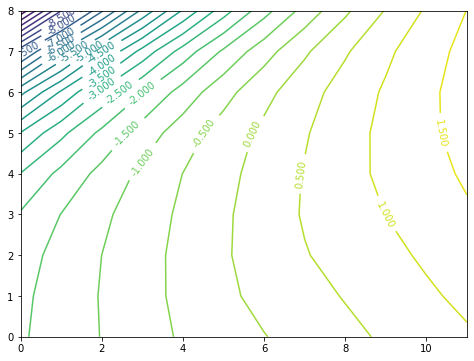

In [13]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(bb_matrix, 30)
plt.clabel(cs, fontsize=10)

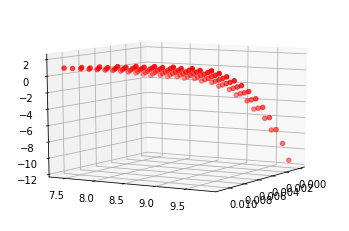

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Edd_r, Mbh, bb, c= 'r', marker= 'o')
ax.view_init(10, 30)
plt.show()

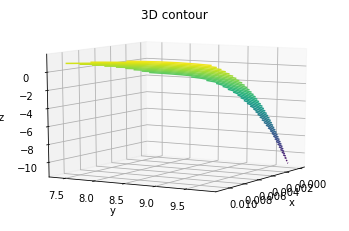

In [15]:
from mpl_toolkits import mplot3d
X, Y = np.meshgrid(SN12dict['logEddra-values'][0:12], SN12dict['logBHmass-values'])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X,Y, bb_matrix, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D contour')
ax.view_init(10, 30)
plt.show()

Text(-0.03685266790122222, -0.08366966968990466, 'BB')

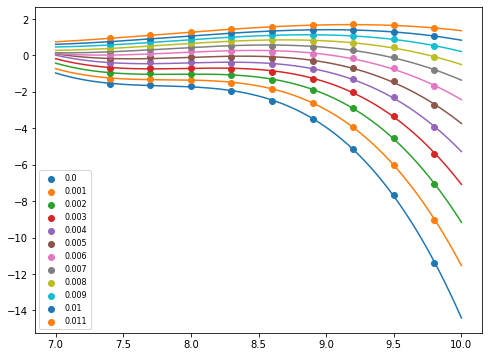

In [16]:
def bb_func(mbh, a, b, c, d):
    return a*mbh**3 + b*mbh**2 +c*mbh + d


edd_par = np.zeros((12, 5))
fig = plt.figure(figsize=(8, 6))
for i in range(12):
    plt.scatter(parameters[i::12][:,1], parameters[i::12][:,0], label = str(parameters[i][2]))
    p, pcov = optimize.curve_fit(bb_func, parameters[i::12][:,1], parameters[i::12][:,0])
    x = np.linspace(7,10, 500)
    plt.plot(x, bb_func(x, p[0], p[1], p[2], p[3]))
    edd_par[i]= [parameters[i][2], p[0], p[1], p[2], p[3]]
plt.legend(fontsize = 8)
ax.set_xlabel('Black hole mass')
ax.set_ylabel('BB')

[ 7.13208873e-03 -2.33120630e-01  1.26263980e+02  3.44714787e+01]
[ 7.21371877e-03  5.40967804e+00 -2.94889247e+03 -8.09975018e+02]
[ 7.29756532e-03 -4.13642480e+01  2.30403566e+04  6.37559241e+03]
[ 7.38454582e-03  1.04548247e+02 -5.99327479e+04 -1.66089217e+04]


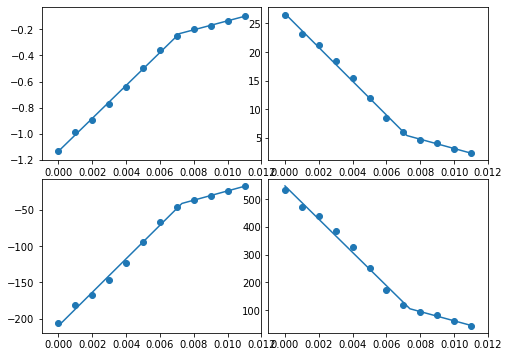

In [17]:
plt.figure(figsize = (8,6))
fig = gridspec.GridSpec(2, 2)
fig.update(wspace=0.03, hspace=0.12)
plt.subplot(fig[0])
plt.scatter(edd_par[:,0], edd_par[:,1])

def a_func(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*(x-x0) + y0, lambda x:k2*(x-x0) + y0])

pa, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,1], [0.007, -0.1, 150, 30])
print(pa)
x = np.linspace(edd_par[:,0].min(), edd_par[:,0].max(), 500)
plt.plot(x, a_func(x, *pa))
plt.xlim(-0.001, 0.012)

plt.subplot(fig[1])
plt.scatter(edd_par[:,0], edd_par[:,2])
pb, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,2], [0.007, 5, -2500, -800])
print(pb)
plt.plot(x, a_func(x, *pb))
plt.xlim(-0.001, 0.012)

plt.subplot(fig[2])
plt.scatter(edd_par[:,0], edd_par[:,3])
pc, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,3], [0.007,  -40, 2500, 6000])
print(pc)
plt.plot(x, a_func(x, *pc))
plt.xlim(-0.001, 0.012)

plt.subplot(fig[3])
plt.scatter(edd_par[:,0], edd_par[:,4])
pd, pcov = optimize.curve_fit(a_func, edd_par[:,0], edd_par[:,4], [0.007,  100, -50000, -16000])
print(pd)
plt.plot(x, a_func(x, *pd))
plt.xlim(-0.001, 0.012)
plt.show()

factor_b = np.array([pb[i]/pa[i] for i in range(1,4)]).mean()
factor_c = np.array([pc[i]/pa[i] for i in range(1,4)]).mean()
factor_d = np.array([pd[i]/pa[i] for i in range(1,4)]).mean()

In [18]:
def bb_surf_mean(eddr, mbh):
    a = a_func(eddr, *pa)
    b = a_func(eddr, pa[0], pa[1]*factor_b, pa[2]*factor_b, pa[3]*factor_b)
    c = a_func(eddr, pa[0], pa[1]*factor_c, pa[2]*factor_c, pa[3]*factor_c)
    d = a_func(eddr, pa[0], pa[1]*factor_d, pa[2]*factor_d, pa[3]*factor_d)
    
    return a*mbh**3 + b*mbh**2 +c*mbh + d

In [19]:
def bb_surf(eddr, mbh):
    """
    Function to calculate BB from the black hole mass and Eddington accretion rate. BB is calculated from a 
    grade 3 polynomial that depends on black hole mass and which parameters are piecewise functions of the
    Eddington accretion rate. The parameters in piecewise functions used here were fitted to data previously
    to save time in computing. The data used to fit the functions comes from a minization routine that calculates
    the best BB in a range between -12 and 2 that makes R06 model as close as possible to each SN12 models for a
    given logEddra and logBHmass.
    
    Parameters:
    -----------
    eddr : logEddra in units of [log Mdot/Medd]
    mbh : logBHmass in units of [log Mbh / Musn]
    
    Return:
    ----------
    BB : Value of the accretion disk normalization
    """      
    def par_func(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*(x-x0) + y0, lambda x:k2*(x-x0) + y0])

    pa = np.array([7.13208873e-03, -2.33120630e-01,  1.26263980e+02,  3.44714787e+01])
    pb = np.array([ 7.21371877e-03,  5.40967804e+00, -2.94889247e+03, -8.09975018e+02])
    pc = np.array([ 7.29756532e-03, -4.13642480e+01,  2.30403566e+04,  6.37559241e+03])
    pd = np.array([ 7.38454582e-03,  1.04548247e+02, -5.99327479e+04, -1.66089217e+04])
    
    a = par_func(eddr, *pa)
    b = par_func(eddr, *pb)
    c = par_func(eddr, *pc)
    d = par_func(eddr, *pd)
    
    BB = a*mbh**3 + b*mbh**2 +c*mbh + d
    return BB

In [33]:
%matplotlib inline 
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Edd_r, Mbh, bb, c= 'r', marker= 'o')
X, Y = np.meshgrid(SN12dict['logEddra-values'][0:12], SN12dict['logBHmass-values'])
Z = bb_surf(X,Y)
ax.plot_surface(X, Y, Z, linewidth=0)
ax.view_init(10, 45)
plt.show()

# Schreiber with and without radio

In [24]:
def RADIO(LIR, conv_factor, sb_nu0, sb_Fnu0, rad_excess):
    
    q_IR_r14 = np.random.normal(2.64, 0.26,1)
    alpha_syn  = -0.75
    alpha_th = -0.1
    nth_frac =0.9

    L14 = 10**(np.log10(LIR*conv_factor)-q_IR_r14)/3.75e12#1.4e9 #to Wats
    nu_spacing= (np.log10(sb_nu0)[2]-np.log10(sb_nu0)[1])
    radio_points = (np.log10(sb_nu0)[0]-9)/nu_spacing
    radio_nu14= np.log10(1.4e9)

    radio_nu = np.arange(np.log10(sb_nu0)[0]- nu_spacing*int(radio_points),np.log10(sb_nu0)[0], nu_spacing)
    radio_nu2 = np.concatenate((radio_nu, np.log10(sb_nu0)[:np.argmax(sb_Fnu0)]))
    all_nu=  np.concatenate((radio_nu, np.log10(sb_nu0)))

    Lsb = np.concatenate((sb_Fnu0[0]*1e-4*np.ones(len(all_nu)-len(sb_Fnu0)),sb_Fnu0))

    Lsyn_0 = 10**(-1*alpha_syn* np.log10(1.4e9/10**radio_nu2[0])) * L14*(nth_frac)* rad_excess
    Lsyn_rad = Lsyn_0 * 10**(alpha_syn* np.log10(10**radio_nu2/10**radio_nu2[0])) 
    Lsyn = np.concatenate((Lsyn_rad, Lsyn_rad[-1]*1e-4*np.ones(len(all_nu)-len(Lsyn_rad))))

    Lth_0 = 10**(-1*alpha_th* np.log10(1.4e9/10**radio_nu2[0])) * L14*(1.-nth_frac)
    Lth_rad= Lth_0* 10**(alpha_th* np.log10(10**radio_nu2/10**radio_nu2[0])) 
    Lth = np.concatenate((Lsyn_rad, Lsyn_rad[-1]*1e-4*np.ones(len(all_nu)-len(Lsyn_rad))))

    Lir_rad= Lsb+Lsyn+Lth

    return  all_nu, Lir_rad

In [15]:
dusttable = Table.read('Models/s17_lowvsg_dust.fits')
pahstable = Table.read('Models/s17_lowvsg_pah.fits')
dusttable

"LAM [150,721]","SED [150,721]",UMIN [150],UMEAN [150],LIR [150],LFIR [150],LBOL [150],L8 [150],TDUST [150],TDUST_PEAK [150],TDUST_LW [150],MASS_FRAC
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.09877818422634621 .. 30000.000000000007,2.884989700633898e-21 .. 2.022607313608977e-06,0.09999999999999998 .. 300.0,0.26451371122875333 .. 790.6332857549645,47.19987698458022 .. 140477.49664224335,12.490381652138764 .. 60242.971781359236,47.5517640169814 .. 141577.51531377863,0.3570634660939377 .. 2685.8364398607937,14.241288337446223 .. 60.21153795212259,15.266432244713348 .. 66.19604567557667,17.987179747228364 .. 74.05456213680702,0.97715


In [20]:
Dwl, DnuLnu = dusttable['LAM'],dusttable['SED'] #micron, Lsun
Pwl, PnuLnu = pahstable['LAM'],pahstable['SED'] #micron, Lsun
Tdust = np.array(dusttable['TDUST'])[0] #K
LIR=  np.array(dusttable['LIR'])[0]
fracPAH = np.concatenate(((np.arange(0.0, 0.1, 0.01)/100.),(np.arange(0.1, 5.5, 0.1)/100.)))
RADexc= np.arange(0, 100, 5)

idxs=[np.arange(len(Tdust)), np.arange(len(fracPAH)),np.arange(len(RADexc))]
par_idxs_combinations = np.array(list(itertools.product(*idxs)))
conv_factor=1e-6
Dnu= (Dwl[0] * u.micron).to(u.Hz, equivalencies=u.spectral())
Pnu= (Pwl[0] * u.micron).to(u.Hz, equivalencies=u.spectral())
DLnu= np.array(DnuLnu[0])/Dnu *conv_factor #* u.Lsun.to(u.W)
PLnu=np.array(PnuLnu[0])/Pnu *conv_factor#* u.Lsun.to(u.W)

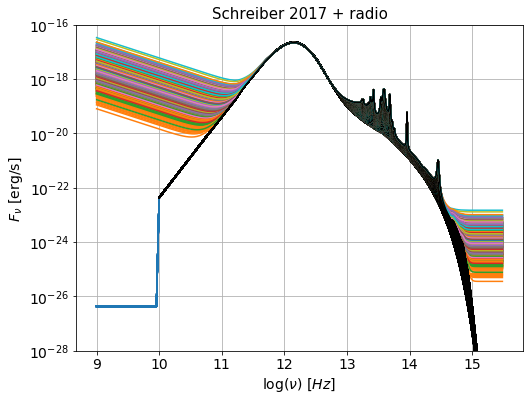

In [47]:
fig = plt.figure(figsize=(8, 6))
for c in par_idxs_combinations[0: 1000]:
    t=c[0]
    fp=c[1]
    re=c[2]

    sb_nu0 = np.array(Dnu[t,:])[::-1]
    sb_Fnu0 = np.array( (1-fracPAH[fp]) * DLnu[t,:] + (fracPAH[fp]) * PLnu[t,:])[::-1]
    rad_sb_nu0 ,rad_sb_Fnu0= RADIO(LIR[t], conv_factor, sb_nu0, sb_Fnu0, RADexc[re])
    plt.semilogy(rad_sb_nu0, rad_sb_Fnu0)
    plt.semilogy(np.log10(sb_nu0), sb_Fnu0, color = 'black')
    
plt.title(r'Schreiber 2017 + radio', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s] ', fontsize = 14) 
plt.ylim(1e-28, 1e-16)
plt.grid(True)

## BB with and without X-Rays

In [167]:
def XRAYS(bbb_nu, bbb_Fnu):
    f = interp1d(bbb_nu, bbb_Fnu, kind = 'nearest', bounds_error=False, fill_value=0.) 
    nu_2500 = (3*1e8)/(2500*1e-10)            #frequency at 2500 Angstroms
    L_2500 = f(np.log10(nu_2500))             # Luminosity at 2500 Angstroms

    alpha = -0.137*np.log10(L_2500) + 2.638   #alpha_OX-L_2500 relation
    nu_2kev = 4.83598*1e17                    #frequency at 2 keV
    xray_nu = np.logspace(np.log10(nu_2500), np.log10(nu_2kev), 500)
    xray_Fnu = L_2500*10**(alpha*(np.log10(xray_nu/nu_2500)))
    bbb_nu_x = np.concatenate((bbb_nu[bbb_nu < np.log10((3*1e8)/(2500*1e-10))], np.log10(xray_nu)))
    bbb_Fnu_x = np.concatenate((bbb_Fnu[bbb_nu < np.log10((3*1e8)/(2500*1e-10))], xray_Fnu))
    
    return bbb_nu_x, bbb_Fnu_x

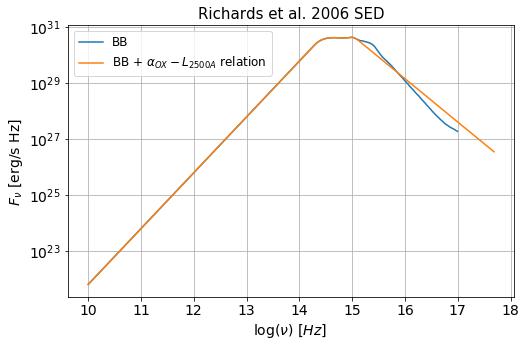

In [168]:
xray_nu_x, xray_Fnu_x = XRAYS(R06dict['wavelength'], R06dict['SED'])

fig = plt.figure(figsize=(8, 5))
plt.semilogy(R06dict['wavelength'], R06dict['SED'], label = 'BB')
plt.semilogy(xray_nu_x, xray_Fnu_x, label = r'BB + $\alpha_{OX}-L_{2500 A}$ relation')
#plt.ylim(1e39, 1e48)
plt.title(r'Richards et al. 2006 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.legend(fontsize = 12)
plt.show()

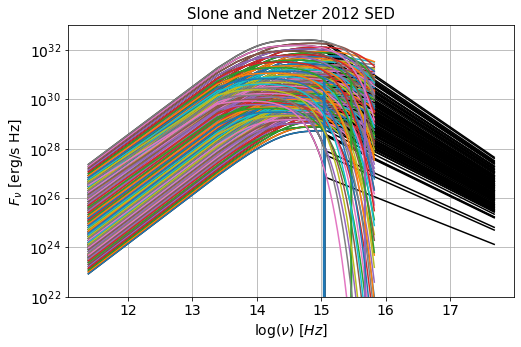

In [169]:
fig = plt.figure(figsize=(8, 5))
for i in range(9): #9
    for j in range(12): #12
        bbb_nu = np.log10(SN12dict['frequency'])
        bbb_Fnu = SN12dict['SED'][:, i, j]
        plt.semilogy(bbb_nu, bbb_Fnu, zorder = 9)
        bbb_nu_x, bbb_Fnu_x = XRAYS(bbb_nu, bbb_Fnu)      
        plt.semilogy(bbb_nu_x, bbb_Fnu_x, color = 'black')
        
plt.ylim(1e22, 1e33)
plt.title(r'Slone and Netzer 2012 SED', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.grid(True)
plt.xlabel(r'log($\nu$) [$Hz$] ', fontsize = 14) 
plt.ylabel(r'$F_\nu$ [erg/s Hz] ', fontsize = 14) 
plt.show()